<a href="https://colab.research.google.com/github/PedroDS4/Identificacao_de_sistemas_nao_lineares/blob/main/Semi_Real_Data_Webots_Non_Linear_System_identification_Pedro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Identificação de Sistemas Não Lineares**
Os sistemas lineares estão presentes em muitos campos de estudo, e muitas vezes eles são assumidos mesmo em modelos não lineares, para simplificação e aplicação de alguns tipos de modelagem, como a modelagem de Laplace ou de fourier.

Os sisteams lineares são caracterizados desse jeito, porque a equação diferencial que rege a dinâmica do sistema tem coeficientes constantes, e assim a saída do sistema pode ser modelada como a convolução da entrada com a resposta ao impulso do mesmo.


Porém, nem sempre a assunção de um sistema ser linear é verdadeira, assim, as vezes é preciso capturar a não linearidade e suas características para que uma precisão seja alcançada para determinada aplicação.


Nesse contexto, a identificação de sistemas não lineares entra, e com ela, é possível, utilizando aprendizado de máquina, capturar a dinâmica não linear de um sistema.


Considere um sistema dada pela equação

$$
\ddot{y}(t) = a_1 \dot{y}(t) + a_0 y(t) + x(t)  
$$

ou ainda em forma de equação de diferenças, temos

$$
y[k+2] = a_1 y[k+1] + a_0 y[k] + x[k]
$$

se os coeficientes $a_1$ e $a_0$ são constantes, o sistema é linear, porém, uma regra geral pra sistemas não lineares pode ser da forma

$$
y[k] = f(y[k-1],y[k-2],x[k],x[k-1])
$$

aqui consideramos causalidade e também que dependem de poucos atrasos no tempo.

Nomeando ainda, todas as variáveis dependentes como uma só, na forma matricial dada por

$$
\mathbf{U}[k] = (y[k-1],y[k-2],x[k],x[k-1])
$$

então o modelo se torna

$$
y[k] = f(\mathbf{U}[k])
$$

Então utilizaremos uma abordagem com funções de base radial, para estimar a não linearidade do sistema, temos então que a saída em função do tempo se torna

$$
y[k] = \sum_{i = 0}^{N_c}  w_i \Phi({ \frac{-||\mathbf{U}[k] - \mathbf{Z}_i||_2^2}{2 \sigma_i^2} })
$$

onde $N_c$ representa o número de funções de base, $\mathbf{Z}$ representa o vetor de centros, $\sigma_i^2$ representa a variância de cada componente da base.


Podemos então fazer um treinamento supervisionado com alguns dados para o sistema, e fazê-lo aprender a dinâmica do sistema utilizando algum algoritmo de otimização para ajustar os pesos $\alpha_j$, e então validar com outra entrada e saída.

A forma vetorial da equação de ajuste é dada por

$$
\mathbf{y} = \mathbf{\Phi} \mathbf{w}
$$

onde $\mathbf{w}$ é o vetor de pesos da rede, e a lei de formação da matriz $\mathbf{\Phi}$ é:

$$
{\Phi}[k,i] = \Phi_{\sigma_i}(\mathbf{U}[k] - \mathbf{Z}_i)
$$

o vetor de pesos ótimo para pode ser encontrado pela solução de mínimos quadrados, então podemos usá-la para fazer o treinamento, assim definimos a função de custo

$$
J(\mathbf{w}) = \frac{1}{2N}||\mathbf{y} - \mathbf{\Phi} \mathbf{w}||_2^2
$$

o ponto de mínimo dessa função é

$$
\mathbf{w} = ( \mathbf{\Phi}^T  \mathbf{\Phi})^{-1}  \mathbf{\Phi}^T \mathbf{y}
$$

assim podemos reconstruir finalmente a saída do sistema como

$$
\mathbf{y}_{est} = \mathbf{\Phi}(\mathbf{U}) \mathbf{w}_{otm}
$$

a função de base escolhida para as implementações foi a inversa multiquadratica, dada por

$$
\phi_{\sigma}(\mathbf{r}) = \frac{1}{\sqrt{1 + \frac{||\mathbf{r}||_2^2}{\sigma^2}}}
$$

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from google.colab import drive

# Caminho do seu arquivo no drive
# Exemplo: /content/drive/MyDrive/log_altura.csv
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
##**Funções**

def f(u, noise_std=0.0):
    """
    Implementa o sistema não linear discreto do artigo:
        y[t+1] = (0.3*y[t] + 0.6*y[t-1] + 0.6*sin(pi*u[t]) + 0.4*sin(3*pi*u[t]))/5.5 + e[t]
    """
    N = len(u)
    y = np.zeros(N)

    # Definir ruído
    noise = np.random.normal(0, noise_std, N)

    # inicialização dos atrasos
    y[0] = 0
    y[1] = 0

    for t in range(1, N-1):
        y[t+1] = (0.3*y[t]
                  + 0.6*y[t-1]
                  + 0.6*np.sin(np.pi*u[t])
                  + 0.4*np.sin(3*np.pi*u[t]))/5.5 \
                  + noise[t]
    return y



def f_pendulo(x,h = 0.01):
  g = 10
  l = 0.1
  N = len(x)
  y = np.zeros(N)
  p = np.zeros(N)

  y[0] = 0.01
  p[0] = 0

  for i in range(0,N-1):
      p[i+1] = p[i] + h*(-g/l*np.sin(y[i]) + x[i])
      y[i+1] = y[i] + h*( p[i] )

  return y





def U_matrix(x, y, x_lags, y_lags):
  N = len(x)
  M_1 = len(x_lags)
  M_2 = len(y_lags)
  U = np.zeros((int(M_1+M_2),N))

  for j in range(M_2):
    lag_y = y_lags[j]
    if lag_y == 0:
      U[j,:] = y
    else:
      U[j,:] = np.concatenate( (np.zeros(lag_y), y[0:-lag_y]) )

  for i in range(M_1):
    lag_x = x_lags[i]
    if lag_x == 0:
      U[i+M_2,:] = x
    else:
      U[i+M_2,:] = np.concatenate( (np.zeros(lag_x), x[0:-lag_x]) )


  return U.T



# def phi_gaussiana(u, c, sigma):
#   phi = np.exp(-(1/(2*(sigma**2)))*la.norm(u-c)**2)
#   return phi


def phi_inv_multiquadrica(u, c, sigma):
  phi = 1/np.sqrt(1 + (la.norm(u-c)/sigma)**2)
  return phi


def Phi(U, c, sigma, phi_rad):
  # U: Matriz com as dependências do sistema
  # N = len(U[0,:])
  N = U.shape[0]
  M = len(c)


  Phi1 = np.zeros(shape = (N,M))

  for i in range(N):
    for j in range(M):
      Phi1[i,j] = phi_rad(U[i],c[j], sigma[j])

  return Phi1



##**Sistema não Linear: Drone No Webots**
Para simular com um dado quase real, vamos simular a resposta de um Drone de quatro motores no Webots(Crazyflie) e verificar se a nossa rede consegue aprender a dinâmica de um sistema real, assim, vamos definir a entrada como sendo um valor de velocidade angular direto, e a saída a posição $z$ do drone em tempo real.


As equações diferenciais que regem o movimento vertical de um drone com quatro hélices/motores como um sistema SISO são:

$$
\begin{cases}
\omega_1 = \omega_2 = \omega_3 = \omega_4 = \omega(t) \\
\ddot{z}(t) = f(\dot{z}(t),z(t), \dot{\omega}(t),\omega(t))
\end{cases}
$$


A força resultante no centro de massa do drone é

$$
F_{res} = -P + F_{helices}
$$

ou seja, para o drone dar partida, a força das 4 hélices precisa superar o peso do próprio drone.

Além disso, pela segunda lei de Newton, em regime transiente a equação de movimento é justamente

$$
m \ddot{z}(t) = -P + F_{helices}(t)
$$

A força das hélices é a força de reação do ar devido ao motor empurrar o mesmo para baixo, e apesar de ser não linear globalmente, o sistema pode ser aproximado por um sistema linear de 2ª ordem na vizinhança do ponto de operação.

Um modelo aceitável para a modelagem da força das hélices é

$$
F_{helices}(t) = K \cdot \omega(t)^2
$$

o que prova a não linearidade do sistema, e a motivação para a utilização da técnica de identificação de sistemas.

Discretizando o modelo para implementação, temos ainda

$$
\begin{cases}
\omega_1 = \omega_2 = \omega_3 = \omega_4 = \omega[k] \\
{z}[k] = f_d(\dot{z}[k-1],z[k-2], \dot{\omega}[k],\omega[k])
\end{cases}
$$

Abaixo é feita a simulação com os dados capturados pelo software Webots.


Dados carregados:
       t           w         z
0  0.032  208.007842  0.002995
1  0.064  215.808947  0.005392
2  0.096  223.201915  0.007310
3  0.128  229.995883  0.008844
4  0.160  236.015451  0.010072


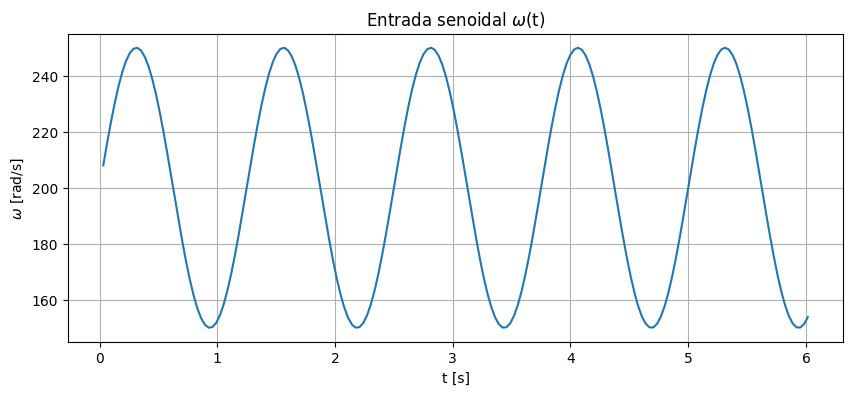

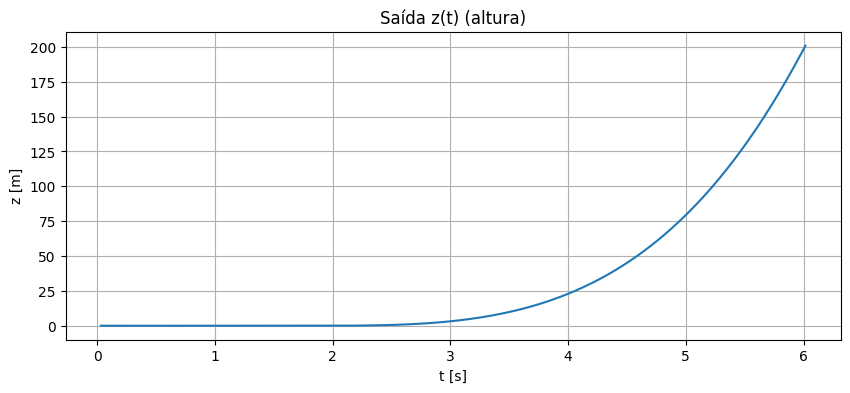

In [262]:

caminho = "/content/drive/MyDrive/Estudos/Identificação_de_Sistemas/log_test_siso.csv"

# Leitura do CSV dos dados de treinamento
df = pd.read_csv(caminho)

# Converte para vetores
t = df["t"].values
omega = df["w"].values
z = df["z"].values

# Debug
print("Dados carregados:")
print(df.head())

# Plots
plt.figure(figsize=(10,4))
plt.plot(t, omega)
plt.title(fr"Entrada senoidal $\omega$(t)")
plt.xlabel("t [s]")
plt.ylabel(fr"$\omega$ [rad/s]")
plt.grid()

plt.figure(figsize=(10,4))
plt.plot(t, z)
plt.title("Saída z(t) (altura)")
plt.xlabel("t [s]")
plt.ylabel("z [m]")
plt.grid()

plt.show()

##**Treinamento**

[150.056996   152.09664592 154.13629584 156.17594576 158.21559568
 160.2552456  162.29489552 164.33454544 166.37419536 168.41384528
 170.4534952  172.49314512 174.53279504 176.57244496 178.61209488
 180.6517448  182.69139472 184.73104464 186.77069456 188.81034448
 190.8499944  192.88964432 194.92929424 196.96894416 199.00859408
 201.048244   203.08789392 205.12754384 207.16719377 209.20684369
 211.24649361 213.28614353 215.32579345 217.36544337 219.40509329
 221.44474321 223.48439313 225.52404305 227.56369297 229.60334289
 231.64299281 233.68264273 235.72229265 237.76194257 239.80159249
 241.84124241 243.88089233 245.92054225 247.96019217 249.99984209]


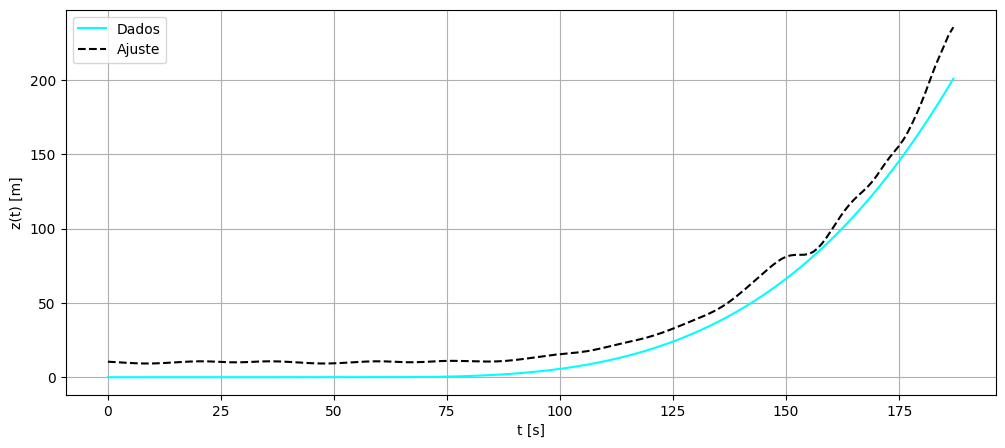

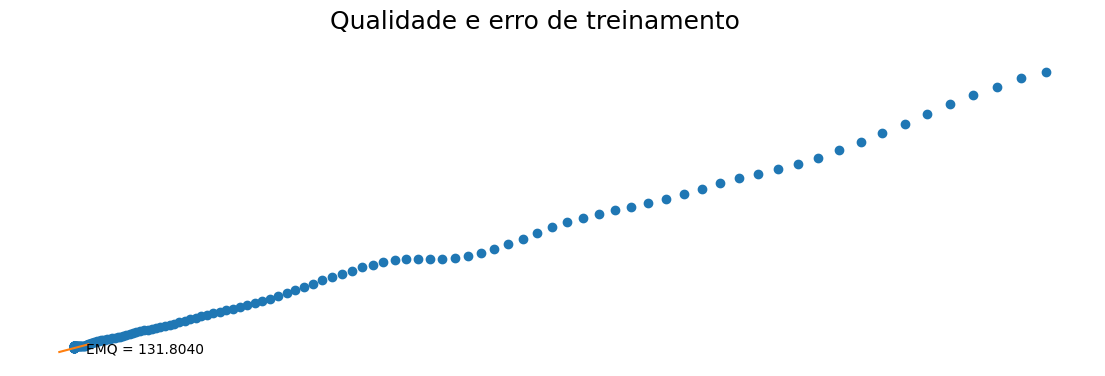

In [263]:
#Definição da entrada e saída
x_1 = omega
y_1 = z

#Vetor de centros das funções de base
c = np.linspace(np.min(x_1),np.max(x_1), 50)

print(c)
sigma = 80*np.ones(M)

#Computação da matriz de estados do sistema
U_1 = U_matrix(x_1, y_1, np.array([0]), np.array([1,2]))

#Computação da matriz Phi
Phi1 = Phi(U_1, c, sigma, phi_inv_multiquadrica)

#Vetor de pesos ótimos do treinamento
w = np.linalg.inv(Phi1.T@Phi1)@Phi1.T@y_1


#Saída da estimada da rede ajustada
y1_est = Phi1@w

#Normalização e Centralização dos vetores para melhor comparação(Opcional dependendo do caso)
# y1_est = y1_est - np.mean(y1_est)
# y1_est = y1_est/np.max(np.abs(y1_est))

# y_1 = y_1 - np.mean(y_1)
# y_1 = y_1/np.max(np.abs(y_1))


plt.figure(figsize = (12, 5))
plt.plot(y_1,'cyan', label = 'Dados')
plt.plot(y1_est, "--",color = "black", label = 'Ajuste')
plt.xlabel("t [s]")
plt.ylabel("z(t) [m]")
plt.legend()
plt.grid()
plt.show()

EMQ = np.mean((y_1 - y1_est)**2)

p = np.poly1d( np.polyfit(y_1, y1_est, 1) )
t = np.linspace(-3,3,500)

plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de treinamento", fontsize=18, y=1)
plt.plot(y_1, y1_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

Dados carregados:
       t    w         z
0  0.032  0.8  0.002995
1  0.064  1.6  0.005392
2  0.096  2.4  0.007310
3  0.128  3.2  0.008844
4  0.160  4.0  0.010072


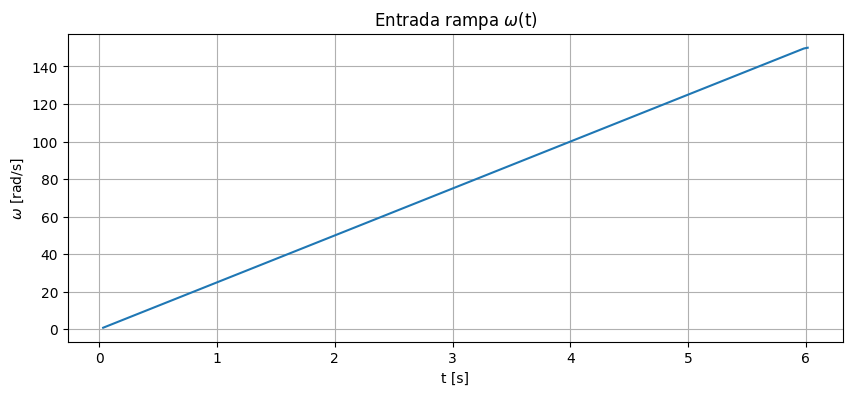

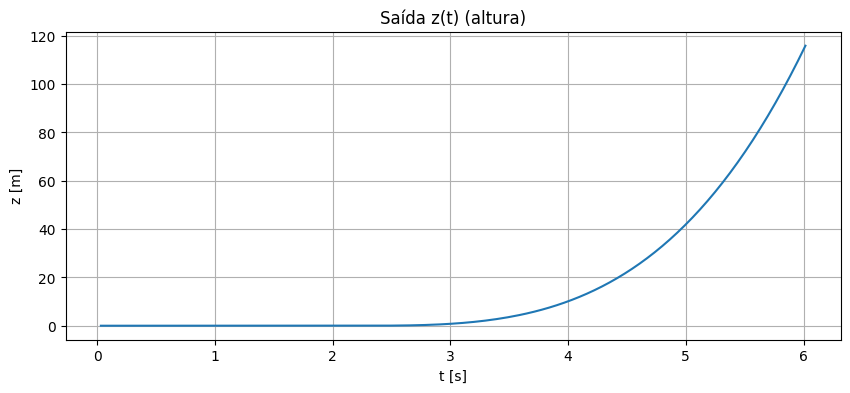

In [264]:
# Caminho do seu arquivo no drive
# Exemplo: /content/drive/MyDrive/log_altura.csv
caminho = "/content/drive/MyDrive/Estudos/Identificação_de_Sistemas/log_train_siso.csv"

# Lê o CSV
df = pd.read_csv(caminho)

# Converte para vetores
t = df["t"].values
omega = df["w"].values
z = df["z"].values

# Debug
print("Dados carregados:")
print(df.head())

# Plots
plt.figure(figsize=(10,4))
plt.plot(t, omega)
plt.title(fr"Entrada rampa $\omega$(t)")
plt.xlabel("t [s]")
plt.ylabel(fr"$\omega$ [rad/s]")
plt.grid()

plt.figure(figsize=(10,4))
plt.plot(t, z)
plt.title("Saída z(t) (altura)")
plt.xlabel("t [s]")
plt.ylabel("z [m]")
plt.grid()

plt.show()

##**Validação**

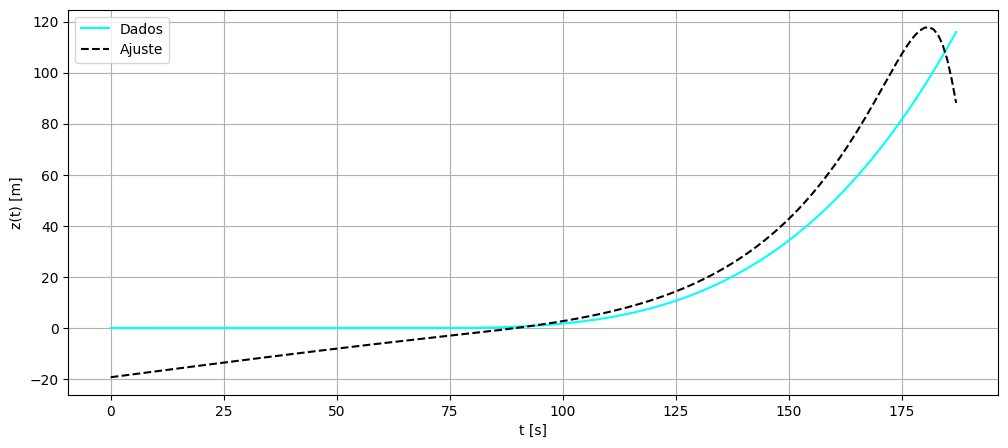

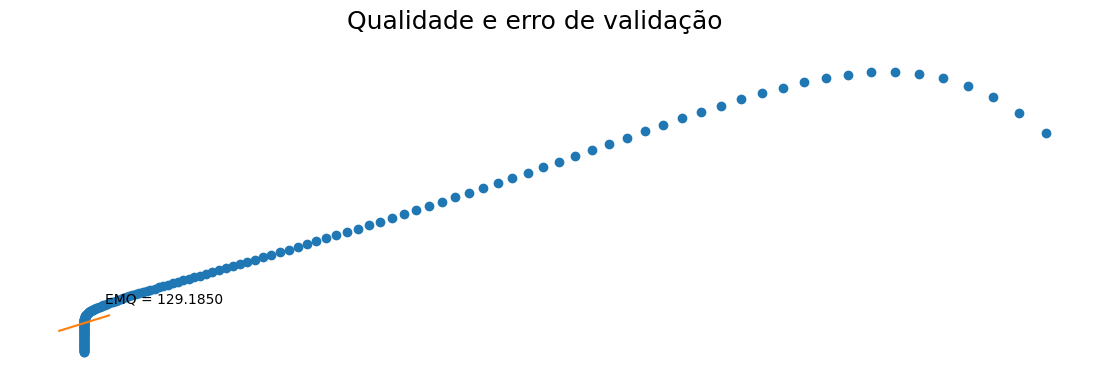

In [265]:
##Validação

#Definição da entrada e saída
x_2 = omega
y_2 = z

#Computação da matriz de estados do sistema
U_2 = U_matrix(x_2, y_2, np.array([0]), np.array([1,2]))

#Computação da matriz Phi com mesmo centros e variâncias
Phi2 = Phi(U_2, c, sigma, phi_inv_multiquadrica)


#Validação do sistema estimado pelos pesos de treinamento
y2_est = Phi2@w

#Normalização e Centralização dos dados(Opcional dependendo do caso)
# y2_est = y2_est - np.mean(y2_est)
# y2_est = y2_est/np.max(np.abs(y2_est))

# y_2 = y_2 - np.mean(y_2)
# y_2 = y_2/np.max(np.abs(y_2))


EMQ = np.mean((y_2 - y2_est)**2)

p = np.poly1d( np.polyfit(y_2, y2_est, 1) )
t = np.linspace(-3,3,500)






plt.figure(figsize = (12, 5))
plt.plot(y_2,'cyan', label = 'Dados')
plt.plot(y2_est, "--",color = "black", label = 'Ajuste')
plt.xlabel("t [s]")
plt.ylabel("z(t) [m]")
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize = (14,4))

plt.suptitle("Qualidade e erro de validação", fontsize=18, y=1)
plt.plot(y_2, y2_est, 'o', t, p(t), '-')
plt.text(2.5, 4.7, 'EMQ = %.4f' %EMQ)
plt.axis('off')
plt.show()

##**Referências**
[1]
Jurnal Teknologi, 36(A) Jun. 2002: 39–54
© Universiti Teknologi Malaysia
RADIAL BASIS FUNCTION (RBF) FOR NON-LINEAR DYNAMIC
SYSTEM IDENTIFICATION
ROBIAH AHMAD1
 & HISHAMUDDIN JAMALUDDIN2

[2] The Matrix Cookbook
[ http://matrixcookbook.com ]
Kaare Brandt Petersen
Michael Syskind Pedersen
Version: November 15, 2012


[3] Robô Utilizado do software Webots: https://cyberbotics.com/doc/guide/crazyflie?version=R2022b

[4] Github com códigos de Exemplo para simulação do robô Crazyflie: https://github.com/bitcraze/crazyflie-simulation/blob/main/simulator_files/webots/controllers/crazyflie_controller_py/crazyflie_controller_py.py